In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))

from berp.generators import RRDataset, thresholded_recognition
from berp.models.reindexing_regression import ModelParameters
from berp.util import time_to_sample, sample_to_time

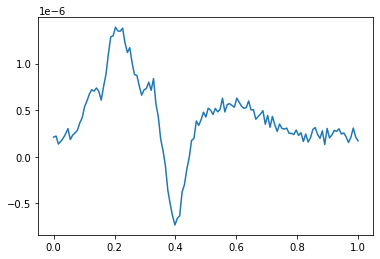

In [4]:
xs, ys = thresholded_recognition.simulate_erp(1.)
plt.plot(xs, ys)

In [5]:
item = thresholded_recognition.sample_item("In the episode, she learns that her then estranged husband is releasing a new song",
                                           recognition_threshold=torch.tensor(0.9))
X_word, X_phon, y = item[:3]

in the episode she learns that her then estranged husband is releasing a new song


In [6]:
X_word

,token,time,recognition_point,surprisal
token_idx,,,,
0,the,0.078125,0,5.385768
1,episode,0.617188,2,11.345507
2,she,1.406250,3,9.465185
3,learns,1.781250,2,9.862487
4,that,2.359375,2,1.192770
5,her,2.710938,0,3.989702
6,then,3.242188,3,12.735794
7,estranged,3.609375,2,10.160424
8,husband,4.242188,0,1.075088


In [7]:
X_phon

time phoneme  surprisal
token_idx phon_idx                             
0         0         0.078125       t   6.427950
          1         0.117188       h   6.438888
          2         0.210938       e   6.727632
1         0         0.500000       e  12.687370
          1         0.578125       p  12.372894
...                      ...     ...        ...
12        2         6.382812       w   6.230085
13        0         6.703125       s   6.743157
          1         6.796875       o   6.656165
          2         6.851562       n   6.423347
          3         6.898438       g   6.580807

[65 rows x 3 columns]

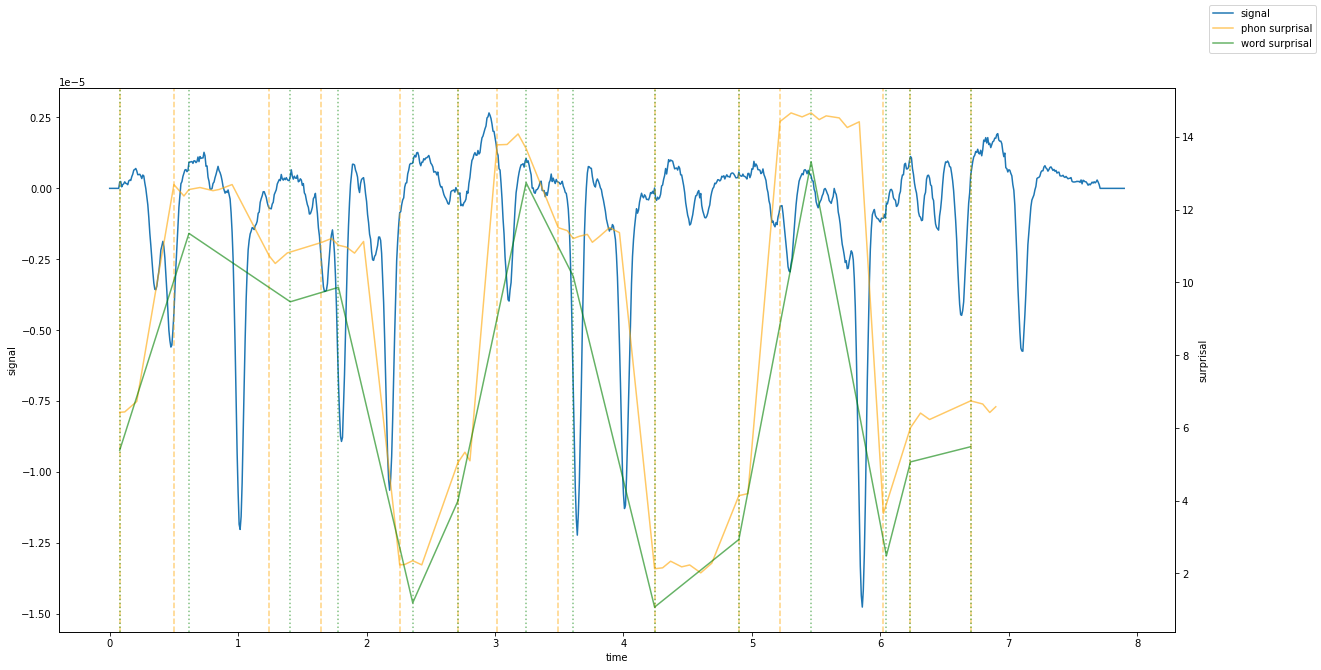

In [8]:
plt.subplots(figsize=(20, 10))
ax = sns.lineplot(data=y, x="time", y="signal")
twinx = ax.twinx()
sns.lineplot(data=X_phon, x="time", y="surprisal", color="orange", alpha=0.6, ax=twinx)
sns.lineplot(data=X_word, x="time", y="surprisal", color="green", alpha=0.6, ax=twinx)
ax.figure.legend(["signal", "phon surprisal", "word surprisal"])

word_onsets = X_phon.groupby("token_idx").apply(lambda xs: xs.iloc[0]).time
for _, phon in X_phon.iterrows():
    ax.annotate(phon.phoneme, xy=(phon.time, 0.1))
for onset in word_onsets:
    ax.axvline(onset, linestyle="--", color="orange", alpha=0.5)
for recognition_onset in X_word.time:
    ax.axvline(recognition_onset, linestyle=":", color="green", alpha=0.5)

## Generate whole dataset

In [95]:
sys.path.append("scripts")
import regression_reindexing_synth as synth
sentences = synth.generate_sentences()

In [96]:
raw_dataset = thresholded_recognition.sample_raw_dataset(sentences)
dataset = thresholded_recognition.preprocess_dataset(raw_dataset, epoch_window=(-0.1, 1.0))

  0%|          | 0/22 [00:00<?, ?it/s]

alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversation
so she was considering in her own mind as well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisychain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her
there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear
oh dear
i shall be late
when she thought it over afterwards it occurred to her that she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually took a watch out of its waistcoatpocket and looked at it and then hurried on alice started to he

  0%|          | 0/292 [00:00<?, ?it/s]

In [97]:
y_df = pd.DataFrame(dataset.Y_epoch.numpy().squeeze())
y_df.index.name = "cum_token_idx"
y_df.columns.name = "epoch_sample"
y_df = y_df.unstack().rename("signal").reset_index()
y_df["time"] = y_df.epoch_sample / dataset.sample_rate + dataset.epoch_window[0]

In [98]:
epoch_baselines = y_df[y_df.time <= 0].groupby("cum_token_idx").signal.mean()
y_df["signal_baselined"] = y_df.signal - y_df.cum_token_idx.map(epoch_baselines)

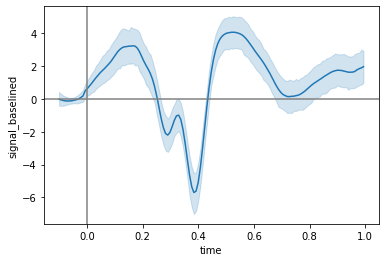

In [99]:
ax = sns.lineplot(data=y_df, x="time", y="signal_baselined")
ax.axvline(0, c="gray")
ax.axhline(0, c="gray")

### N400 replication

With ground-truth recognition onset information, can we reproduce an N400 effect with ERP analysis?

In [52]:
def time_window_to_sample(window, sample_rate, t_zero=0.):
    left, right = window
    
    left = int(np.floor((left - t_zero) * sample_rate))
    right = int(np.floor((right - t_zero) * sample_rate))
    return (left, right)

def compute_erp(dataset: RRDataset,
                baseline_window=(-0.1, 0),
                test_window=(0.3, 0.5),
                ) -> pd.DataFrame:
    baseline_left_samp, baseline_right_samp = time_window_to_sample(baseline_window, dataset.sample_rate,
                                                                    t_zero=dataset.epoch_window[0])
    test_left_samp, test_right_samp = time_window_to_sample(test_window, dataset.sample_rate,
                                                            t_zero=dataset.epoch_window[0])
    
    baseline_values = dataset.Y_epoch[:, baseline_left_samp:baseline_right_samp, 0]
    test_values = dataset.Y_epoch[:, test_left_samp:test_right_samp, 0]

    return pd.DataFrame({"cum_token_idx": np.arange(len(dataset.Y_epoch)),
                         "baseline_value": baseline_values.mean(dim=1),
                         "test_value": test_values.mean(dim=1)})

In [53]:
erp_df = compute_erp(dataset)

In [66]:
dataset.Y_epoch.max()

tensor(2.2860e-06)

In [55]:
erp_df

,cum_token_idx,baseline_value,test_value
0,0,-2.028421e-11,-0.000007
1,1,-1.210018e-05,-0.000010
2,2,-3.778990e-07,-0.000019
3,3,-1.847908e-05,-0.000001
4,4,7.559624e-07,-0.000008
5,5,-1.202153e-05,-0.000008
6,6,-1.003522e-05,-0.000010
7,7,-1.047989e-05,-0.000001
8,8,-4.628799e-07,-0.000014
9,9,-1.260664e-05,-0.000003


In [58]:
epochs = thresholded_recognition.dataset_to_epochs(raw_dataset.X_word, raw_dataset.y)

  0%|          | 0/38 [00:00<?, ?it/s]

In [59]:
baseline_window = (-.1, 0)
test_window = (0.3, 0.5)
df_test = epochs.groupby(["item", "token_idx"]).apply(
    lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
                            "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [61]:
merged_df = pd.merge(df_test, raw_dataset.X_word, left_index=True, right_index=True)
merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

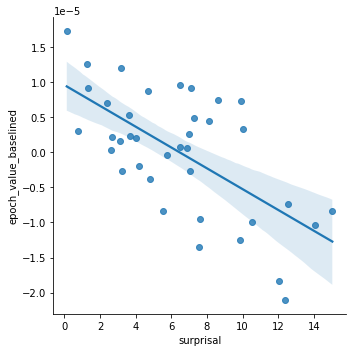

In [62]:
sns.lmplot(data=merged_df, x="surprisal", y="epoch_value_baselined")

In [63]:
st.pearsonr(merged_df.surprisal, merged_df.epoch_value_baselined)

(-0.6433417967049866, 1.3213418425690635e-05)

### N400 replication without ground truth

If we assume recognition onset happens at first phoneme onset, does the effect still show?

In [69]:
X_word_simplified = raw_dataset.X_word.copy()
X_word_simplified["time_gt"] = X_word_simplified.time
X_word_simplified["time"] = raw_dataset.X_phon.xs(0, level="phon_idx").time
assert (X_word_simplified.time <= X_word_simplified.time_gt).all()
X_word_simplified

token      time  recognition_point  surprisal   time_gt
item token_idx                                                               
0    0                  ice  0.046875                  2  12.528906  0.203125
     1                  was  0.437500                  0   6.968839  0.437500
     2            beginning  0.890625                  2  12.062911  1.023438
     3                   to  1.687500                  0   0.133897  1.687500
     4                  get  1.898438                  0   5.561836  1.898438
     5                 very  2.164062                  2   8.114810  2.289062
     6                tired  2.656250                  0   5.736715  2.656250
     7                   of  3.164062                  0   1.321283  3.164062
     8              sitting  3.500000                  2   7.574335  3.640625
     9                   by  4.070312                  1   6.508747  4.156250
     10                 her  4.453125                  0   2.687846  4.453125
     11              sister  4.757812                  3   7.619429  5.031250
     12                  on  5.515625                  0   7.288497  5.515625
     13                 the  5.820312                  0   0.787417  5.820312
     14                bank  6.234375                  2  10.504301  6.375000
     15                 and  6.750000                  0   4.680663  6.750000
     16                  of  7.109375                  1  10.028923  7.195312
     17              having  7.500000                  0   4.013812  7.500000
     18             nothing  7.984375                  0   7.036338  7.984375
1    0                  she  0.093750                  0   9.850457  0.093750
     1                  was  0.500000                  1   3.193451  0.570312
     2          considering  0.906250                  2  12.369246  1.093750
     3                   in  1.882812                  2   9.915692  1.984375
     4                  her  2.250000                  0   3.630440  2.250000
     5                  own  2.617188                  0   4.193939  2.617188
     6                 mind  3.000000                  0   4.785539  3.000000
     7                   as  3.375000                  2   8.617601  3.437500
     8                 well  3.679688                  0   2.635717  3.679688
     9                   as  4.070312                  0   3.108851  4.070312
     10                 she  4.429688                  2   6.904125  4.546875
     11               could  4.835938                  0   3.702901  4.835938
     12                 for  5.312500                  0   6.480115  5.312500
     13                 the  5.687500                  0   2.391686  5.687500
     14                 hot  6.117188                  3  14.047598  6.281250
     15                 day  6.429688                  1   7.090827  6.523438
     16                made  6.851562                  3  15.038711  7.093750
     17                 her  7.351562                  0   1.269525  7.351562
     18                feel  7.789062                  0   3.237452  7.789062

In [71]:
epochs = thresholded_recognition.dataset_to_epochs(X_word_simplified, raw_dataset.y)

  0%|          | 0/38 [00:00<?, ?it/s]

In [72]:
baseline_window = (-.1, 0)
test_window = (0.3, 0.5)
df_test = epochs.groupby(["item", "token_idx"]).apply(
    lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
                            "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [73]:
merged_df = pd.merge(df_test, X_word_simplified, left_index=True, right_index=True)
merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

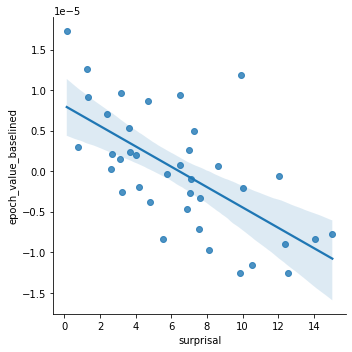

In [74]:
sns.lmplot(data=merged_df, x="surprisal", y="epoch_value_baselined")

In [75]:
st.pearsonr(merged_df.surprisal, merged_df.epoch_value_baselined)

(-0.6454608338321302, 1.2112456483132373e-05)